In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
import os
import shutil
import glob
import h5py
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.compat.v1 import ConfigProto
config = ConfigProto()
config.gpu_options.allow_growth = True

In [2]:
training_samps = 100000
training_dataset = 'v1b'
trim_secs = [2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 12.5, 15, 17.5, 20, 25, 30, 35, 40, 45, 50, 55, 60]
test_trim_secs = [60]
shift_status = 'shifted'
# model_folder_path = '/home/sdybing/neic-mlaapde/dataaugment/p-only/'
model_folder_path = '/home/sdybing/neic-mlaapde/dataaugment/p-only/redo_augcode/looprun/goagain/v1b_100000samp_120s_cutwindow/'
historic_path = '/data/sdybing/olderdata/arrays/'
n_channels = 3

In [3]:
historic_test_waves = np.load(historic_path + 'historic_test_waves.npy')
historic_test_mags = np.load(historic_path + 'historic_test_mags.npy')

In [4]:
nsamp = len(historic_test_waves)

In [5]:
print(historic_test_waves.shape)
print(historic_test_mags.shape)

q = np.isnan(historic_test_waves)
r = np.where(q == True)[0]
print(r)

(13449, 4800, 3)
(13449,)
[   20    20    20 ... 13447 13447 13447]


In [6]:
# Training/model params
epochs_number = 200
batch_size = int(256) # Reducing to help memory
monte_carlo_sampling = 50
drop_rate = 0.5
filters = [32, 64, 96, 128, 256] 

inp1 = tf.keras.layers.Input(shape = (4800, n_channels), name = 'input_layer') # (cut_len - max_shift)*sr
e = tf.keras.layers.Conv1D(filters[1], 3, padding = 'same')(inp1) 
e = tf.keras.layers.Dropout(drop_rate)(e, training = True)
e = tf.keras.layers.MaxPooling1D(4, padding = 'same')(e)
e = tf.keras.layers.Conv1D(filters[0], 3, padding = 'same')(e) 
e = tf.keras.layers.Dropout(drop_rate)(e, training = True)
e = tf.keras.layers.MaxPooling1D(4, padding = 'same')(e)
e = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences = False, dropout = 0.0, recurrent_dropout = 0.0))(e)
e = tf.keras.layers.Dense(2)(e)
#e = tf.keras.layers.Dense(1)(e)
o = tf.keras.layers.Activation('linear', name = 'output_layer')(e)
model = tf.keras.models.Model(inputs = [inp1], outputs = o)
#model.summary()

#model.compile(optimizer = 'Adam', loss = customLoss)
model.compile(optimizer = 'Adam', loss = tf.keras.losses.MeanSquaredError())
model.summary()

2022-08-30 17:25:10.729210: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-30 17:25:10.737230: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 4800, 3)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 4800, 64)          640       
_________________________________________________________________
dropout (Dropout)            (None, 4800, 64)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1200, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1200, 32)          6176      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1200, 32)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 300, 32)           0     

In [7]:
### ----- What trained model are we loading? ----- ###

model_path = model_folder_path
#print(model_path)
list_of_models = glob.glob(model_path + '*.h5') # * means all if need specific format then *.csv
#print(list_of_models)
latest_model = max(list_of_models, key=os.path.getctime)
#print(latest_model)

model.load_weights(latest_model)

model_tag = latest_model[-12:-3]
print('Model: ' + str(model_tag))

Model: _117s_082


In [8]:
### ----- Make the predictions ----- ###

predict = model.predict(historic_test_waves)

2022-08-30 17:25:11.775699: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [9]:
print(predict.shape)
print(predict)
a = np.isnan(predict)
print(a)
wherenans = np.where(a == True)[0]
print(wherenans)
print(len(wherenans))
print(predict[wherenans])

predict_nonan = np.delete(predict, wherenans, axis = 0)
print(predict_nonan)
print(predict_nonan.shape)

(13449, 2)
[[ 6.8537703 -2.0458581]
 [ 7.284125  -2.0932105]
 [ 7.7998834 -1.5763053]
 ...
 [ 4.3311305 -0.211063 ]
 [       nan        nan]
 [ 4.938737  -0.9600116]]
[[False False]
 [False False]
 [False False]
 ...
 [False False]
 [ True  True]
 [False False]]
[   20    20    44 ... 13441 13447 13447]
2460
[[nan nan]
 [nan nan]
 [nan nan]
 ...
 [nan nan]
 [nan nan]
 [nan nan]]
[[ 6.8537703  -2.0458581 ]
 [ 7.284125   -2.0932105 ]
 [ 7.7998834  -1.5763053 ]
 ...
 [ 4.276191   -0.18933183]
 [ 4.3311305  -0.211063  ]
 [ 4.938737   -0.9600116 ]]
(12219, 2)


In [10]:
historic_test_waves_nonan = np.delete(historic_test_waves, wherenans, axis = 0)
historic_test_mags_nonan = np.delete(historic_test_mags, wherenans, axis = 0)

print(historic_test_waves.shape)
print(historic_test_mags.shape)
print(historic_test_waves_nonan.shape)
print(historic_test_mags_nonan.shape)

(13449, 4800, 3)
(13449,)
(12219, 4800, 3)
(12219,)


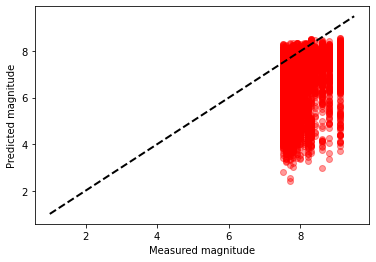

In [11]:
### ----- Quick plot of the predictions vs. true magnitudes ----- ###

fig4, ax = plt.subplots(facecolor = 'white')
ax.scatter(historic_test_mags_nonan, predict_nonan[:,0], alpha = 0.4, facecolors = 'r', edgecolors = 'r')
ax.plot([1, 9.5], [1, 9.5], 'k--', alpha = 1, lw = 2)
ax.set_xlabel('Measured magnitude')
ax.set_ylabel('Predicted magnitude')
plt.show()
#fig4.savefig(save_dir + '/pred_vs_meas_mag_' + m_name + '.png')
plt.close();

In [15]:
measured_eventids = np.load('/data/sdybing/olderdata/arrays/historic_test_eventids.npy')
print(len(measured_eventids))

13449


In [17]:
measured_mags = historic_test_mags_nonan
measured_eventids_nonan = np.delete(measured_eventids, wherenans, axis = 0)
predicted_mags = predict_nonan[:,0]

eventids = np.unique(measured_eventids)
print(eventids)
print(len(eventids))
print(len(measured_eventids_nonan))
print(len(predicted_mags))

test_eventids = eventids[101:115]

['official20010623203314130_33' 'official20030925195006360_27'
 'official20041226005853450_30' 'official20050328160936530_30'
 'official20070912111026830_34' 'official20100227063411530_30'
 'official20110311054624120_30' 'official20120411083836720_20'
 'usb000g7x7' 'usb000h4jh' 'usc000f1s0' 'usp0009qb4' 'usp0009sbh'
 'usp0009txv' 'usp0009ut0' 'usp000a3qq' 'usp000a3sp' 'usp000a45f'
 'usp000a70h' 'usp000a7m5' 'usp000a8ds' 'usp000aj40' 'usp000ar78'
 'usp000asvm' 'usp000azqw' 'usp000ba6g' 'usp000ba6m' 'usp000bbpf'
 'usp000be54' 'usp000bnyr' 'usp000c2ka' 'usp000c41f' 'usp000cd1n'
 'usp000d85g' 'usp000db93' 'usp000dsw1' 'usp000dz2j' 'usp000e09h'
 'usp000e12e' 'usp000e8ys' 'usp000ef1h' 'usp000eg5g' 'usp000ensm'
 'usp000exfn' 'usp000f2ab' 'usp000f34b' 'usp000f83m' 'usp000fj6k'
 'usp000fjta' 'usp000fn2b' 'usp000fpca' 'usp000fshy' 'usp000fu3q'
 'usp000g650' 'usp000gbc0' 'usp000gs2d' 'usp000gv5p' 'usp000gz8j'
 'usp000h05x' 'usp000h1ys' 'usp000h237' 'usp000h2g9' 'usp000h2gd'
 'usp000hat0' 'usp000h

In [18]:
measured_mean_mags = []
predicted_mean_mags = []

for eventid in eventids:
    
    #print(eventid)
    
    idxs = np.where(measured_eventids_nonan == eventid)[0]
    predictions = predicted_mags[idxs]
    measurements = measured_mags[idxs]
    
    #print(predictions)
    #print(measurements)
    
    measured_mean_mag = np.mean(measurements)
    predicted_mean_mag = np.mean(predictions)
    
    #print(measured_mean_mag)
    #print(predicted_mean_mag)
    
    measured_mean_mags.append(measured_mean_mag)
    predicted_mean_mags.append(predicted_mean_mag)

In [19]:
print(len(measured_mean_mags))
print(len(predicted_mean_mags))

76
76


In [20]:
# For the data by individual waveform

errors = []

for idx in range(len(predicted_mags)):

    predicted = predicted_mags[idx]
    #print(prediction)
    measured = measured_mags[idx]

    error = predicted - measured
    errors.append(error)

mean_error = np.mean(np.array(errors))
std_error = np.std(np.array(errors))

print('Mean error: ' + str(round(mean_error,3)))
print('Error standard deviation: ' + str(round(std_error,2)))

Mean error: -0.996
Error standard deviation: 1.03


In [21]:
# The data with event-averaged magnitudes

#print(predicted_mean_mags)

avgd_errors = []

for idx in range(len(np.array(predicted_mean_mags))):
    #print('------')
    predicted = predicted_mean_mags[idx]
    #print(predicted)
    measured = measured_mean_mags[idx]
    #print(measured)

    error = predicted - measured
    #print(error)
    avgd_errors.append(error)
    
avgd_mean_error = np.mean(np.array(avgd_errors))
avgd_std_error = np.std(np.array(avgd_errors))

print('Mean error: ' + str(round(avgd_mean_error,3)))
print('Error standard deviation: ' + str(round(avgd_std_error,2)))

Mean error: -0.995
Error standard deviation: 0.61


(1.0, 9.5)

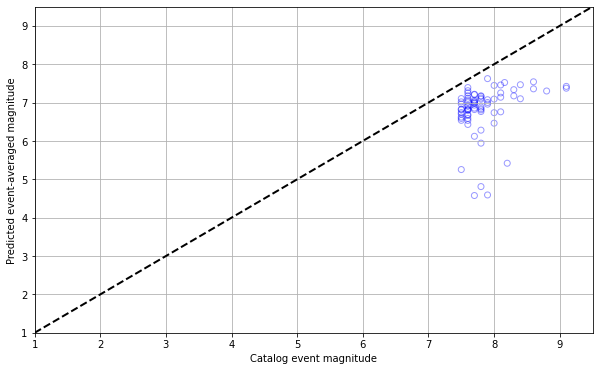

In [22]:
plt.figure(figsize = (10,6), facecolor = 'white')
plt.grid()
plt.scatter(measured_mean_mags, predicted_mean_mags, alpha = 0.4, facecolors = 'none', edgecolors = 'b')
plt.plot([1, 9.5], [1, 9.5], 'k--', alpha = 1, lw = 2)
plt.xlabel('Catalog event magnitude')
plt.ylabel('Predicted event-averaged magnitude')
plt.xlim(1,9.5)
plt.ylim(1,9.5)

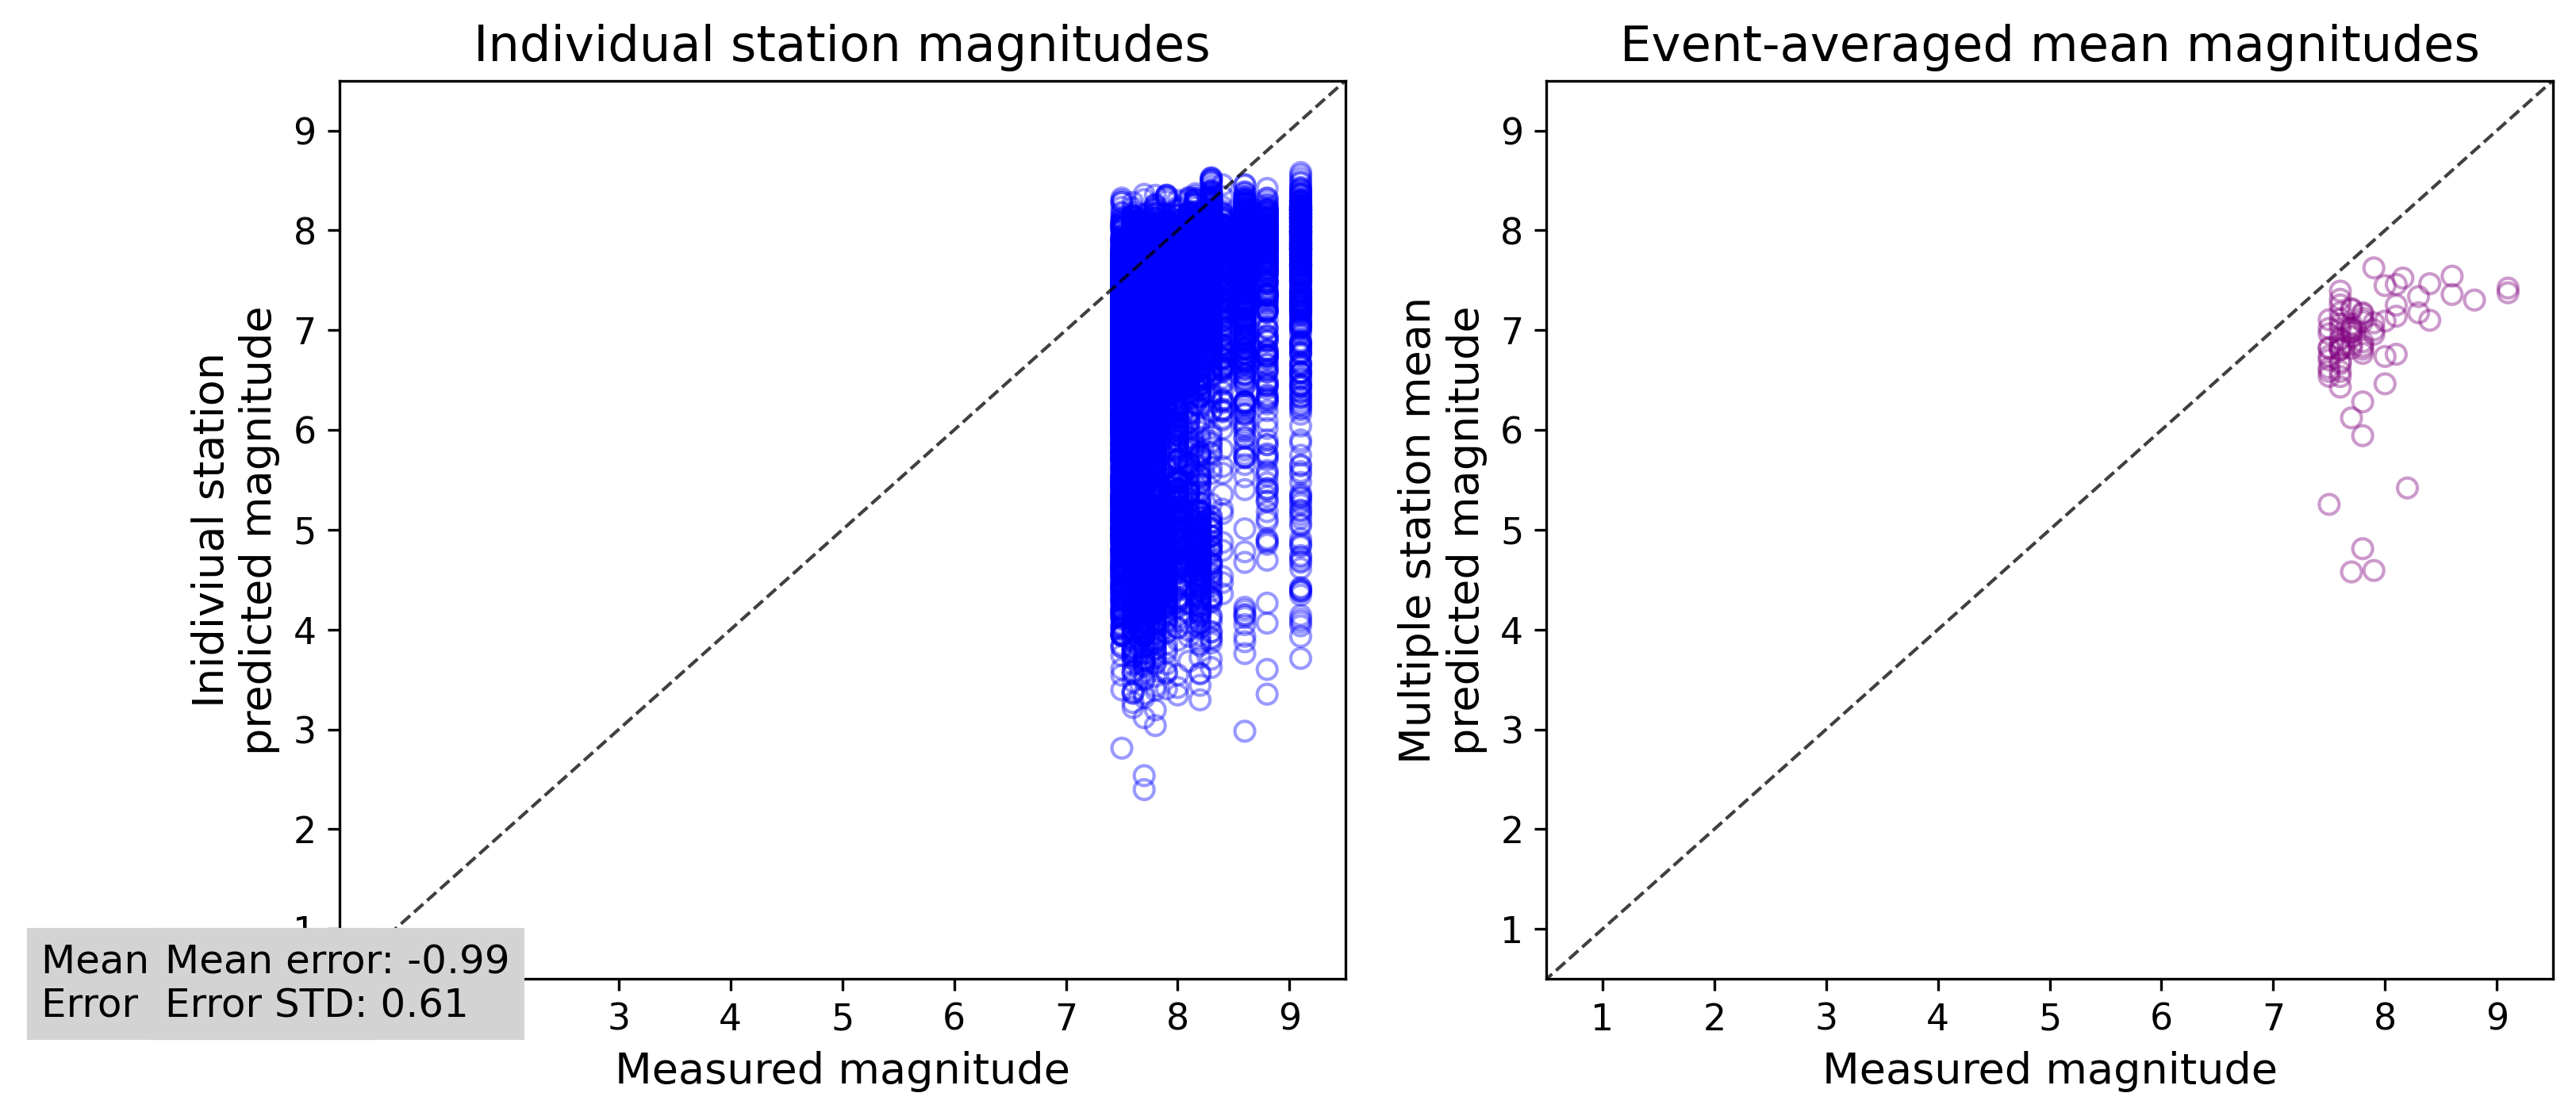

In [23]:
plt.figure(figsize = (12,5), dpi = 300, facecolor = 'white')

plt.subplot(121)
plt.title('Individual station magnitudes', fontsize = 15)
plt.scatter(measured_mags, predicted_mags,  facecolors = 'none', edgecolors = 'blue', alpha = 0.4)
plt.plot([0, 9.5], [0, 9.5], color = 'black', linestyle = '--', linewidth = 1, alpha = 0.75)
plt.xlim(0.5,9.5)
plt.ylim(0.5,9.5)
plt.xlabel('Measured magnitude', fontsize = 13)
plt.ylabel('Inidiviual station\npredicted magnitude', fontsize = 13)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)

plt.subplot(122)
plt.title('Event-averaged mean magnitudes', fontsize = 15)
plt.scatter(measured_mean_mags, predicted_mean_mags,  facecolors = 'none', edgecolors = 'purple', alpha = 0.4)
plt.plot([0, 9.5], [0, 9.5], color = 'black', linestyle = '--', linewidth = 1, alpha = 0.75)
plt.xlim(0.5,9.5)
plt.ylim(0.5,9.5)
plt.xlabel('Measured magnitude', fontsize = 13)
plt.ylabel('Multiple station mean\npredicted magnitude', fontsize = 13)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)

plt.text(x = -0.005, y = 0.408, s = 'Mean error: ' + str(round(mean_error,2)) + '\nError STD: ' + str(round(std_error,2)), fontsize = 12, backgroundcolor = 'lightgray', transform=ax.transAxes)
plt.text(x = 0.46, y = 0.408, s = 'Mean error: ' + str(round(avgd_mean_error,2)) + '\nError STD: ' + str(round(avgd_std_error,2)), fontsize = 12, backgroundcolor = 'lightgray', transform=ax.transAxes);
#plt.savefig(save_dir + '/scatter_comparison_' + model_tag + '.png', facecolor = 'white', transparent = False);

Rupture duration: 60.0 seconds
M0: 1.35e+28 dyne-cm
Mw: 8.02
74


/home/sdybing/miniconda3/envs/mlaapde/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator


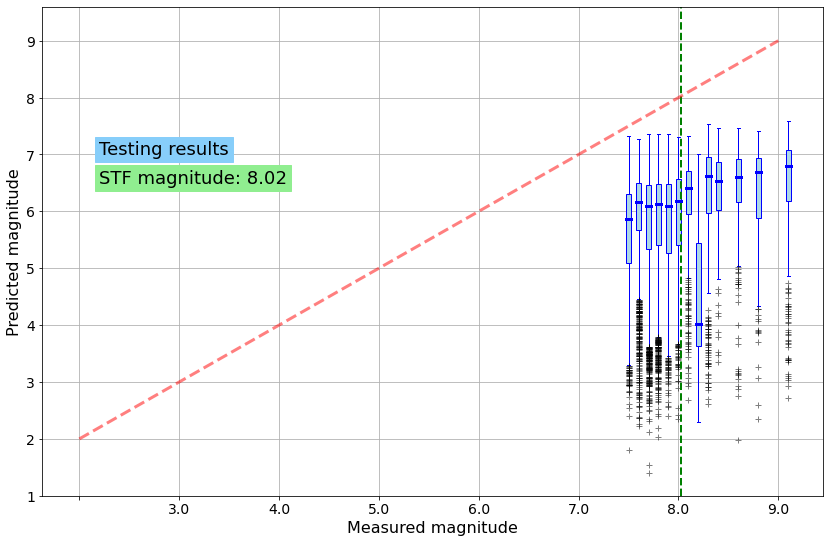

In [55]:
### ----- Make the box and whisker plots with STF magnitude line ----- ###

shift_len = 120 # NOT CORRECT - these are unshifted

Tt = shift_len / 2
M0_dyncm = Tt**3 * (0.625 * 10**23)
Mw = ((2/3) * np.log10(M0_dyncm)) - 10.73 # M0 in dyne-cm

print('Rupture duration: ' + str(Tt) + ' seconds')
print('M0: ' + str(M0_dyncm) + ' dyne-cm')
print('Mw: ' + str(round(Mw,2)))

bins = np.arange(21,95,1)/10
data_bins = []

for abin in bins:
    i = np.where(measured_mags == abin)[0]
    predict_bin = np.array(predicted_mags[i])
    data_bins.append(predict_bin)
    
print(len(data_bins))

#fig = plt.figure(figsize =(14, 9), dpi = 300, facecolor = 'white')
fig = plt.figure(figsize =(14, 9), facecolor = 'white')

#fig.suptitle('MLAAPDE ' + str(dataset) + ' agumented dataset, tested with ' + str(int(valid_split*nsamp)) + ' ' + str(shift_len) + 's window samples shifted up to 3s', fontsize = 18, y = 0.96, color = 'black')
ax = fig.add_subplot(111)
ax.set_facecolor('white')
#ax.text(x = 30, y = 8.8, s = 'Model: ' + m_name, fontsize = 13, color = 'black')
ax.grid(which = 'major', axis = 'y')
ax.grid(which = 'major', axis = 'x', markevery = [10,20,30,40,50])
ax.set_ylim(2,10.6)

bp = ax.boxplot(data_bins, notch = False, patch_artist = True)
ax.axvline((Mw-2)*10, color = 'green', linestyle = '--', linewidth = 2) # Position = (magnitude - 1)*10

for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_edgecolor('blue')
for median in bp['medians']:
    median.set(color ='blue', linewidth = 3)
for whisker in bp['whiskers']:
    whisker.set(color ='blue', linewidth = 1)
for cap in bp['caps']:
    cap.set(color ='blue', linewidth = 1)
for flier in bp['fliers']:
    flier.set(marker ='+', color ='blue', alpha = 0.5)

bins_list = bins.tolist()
ax.set_xticklabels(bins_list, fontsize = 14, color = 'black')
ax.set_yticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9], fontsize = 14, color = 'black')
ax.set_ylabel('Predicted magnitude', fontsize = 16, color = 'black')
ax.set_xlabel('Measured magnitude', fontsize = 16, color = 'black')
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.plot((0,70),(3,10),'r--', linewidth = 3, alpha = 0.5)
#plot([x1, x2], [y1, y2],
ax.text(s = 'Testing results', x = 2, y = 8, fontsize = 18, backgroundcolor = 'lightskyblue', color = 'black')
ax.text(s = 'STF magnitude: ' + str(round(Mw,2)), x = 2, y = 7.5, fontsize = 18, backgroundcolor = 'lightgreen', color = 'black')

plt.show()
#plt.savefig(save_dir + '/boxplot_durline_' + m_name + '.png', format = 'PNG', facecolor = 'white', transparent = False)
plt.close();